In [1]:
# Import modules
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
# scanpy settings
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

results_file = 'results.h5ad'

scanpy==1.7.1 anndata==0.7.5 umap==0.5.1 numpy==1.20.2 scipy==1.6.2 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.9.1 leidenalg==0.8.3


In [21]:
# Read in data into a AnnData object
adata = sc.read_10x_mtx(
    'Raw data/GSM3148577_BC10_TUMOR1',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)  

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [23]:
adata

AnnData object with n_obs × n_vars = 4926 × 33694
    var: 'gene_ids'

In [24]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 17964 genes that are detected in less than 3 cells


In [34]:
# Compute metrics
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

In [35]:
adata

AnnData object with n_obs × n_vars = 4926 × 15730
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts'
    var: 'gene_ids', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

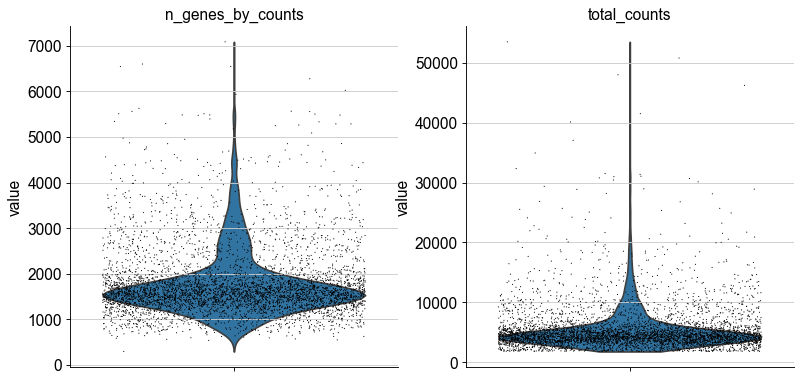

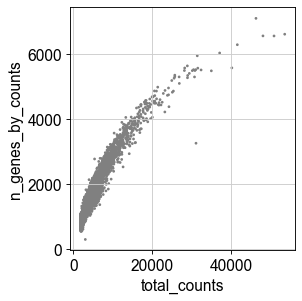

In [37]:
# Check data quality with violin and scatter plots
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'], jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [38]:
# Remove samples with too many gene counts
adata = adata[adata.obs.n_genes_by_counts < 6000, :]

In [39]:
# Normalise and logarithmise the matrix
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

c:\Users\spack\OneDrive - King's College London\Individual Project\scanpy_2\lib\site-packages\scanpy\preprocessing\_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
normalizing counts per cell
    finished (0:00:00)


extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


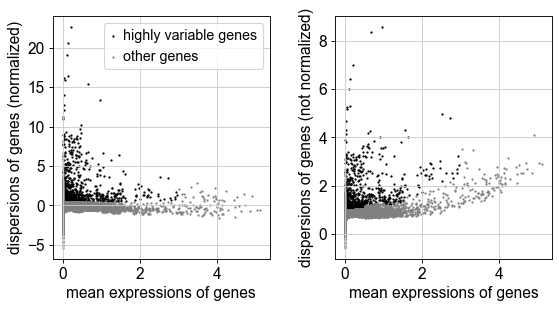

In [40]:
# Identify highly expressed genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [41]:
# Set raw attribute to be the processed data
adata.raw = adata

In [42]:
# Filter out non-highly expressed genes
adata = adata[:, adata.var.highly_variable]

# Scale the data
sc.pp.scale(adata, max_value=10)

c:\Users\spack\OneDrive - King's College London\Individual Project\scanpy_2\lib\site-packages\scanpy\preprocessing\_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


## PCA

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


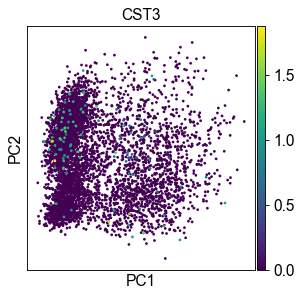

In [46]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata)

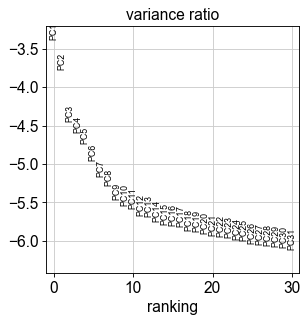

In [47]:
# Identify the PCs contributing to the total variance
sc.pl.pca_variance_ratio(adata, log=True)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


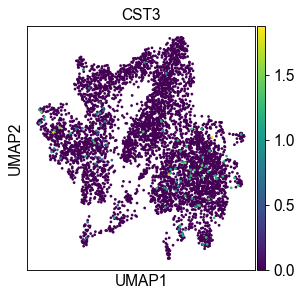

In [54]:
# Carry out UMAP
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

sc.tl.umap(adata)
sc.pl.umap(adata)

## Clustering

In [56]:
# Create clusters
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 16 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


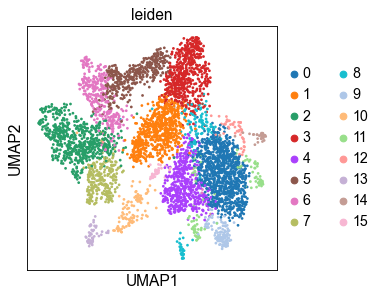

In [57]:
sc.pl.umap(adata, color='leiden')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:10)


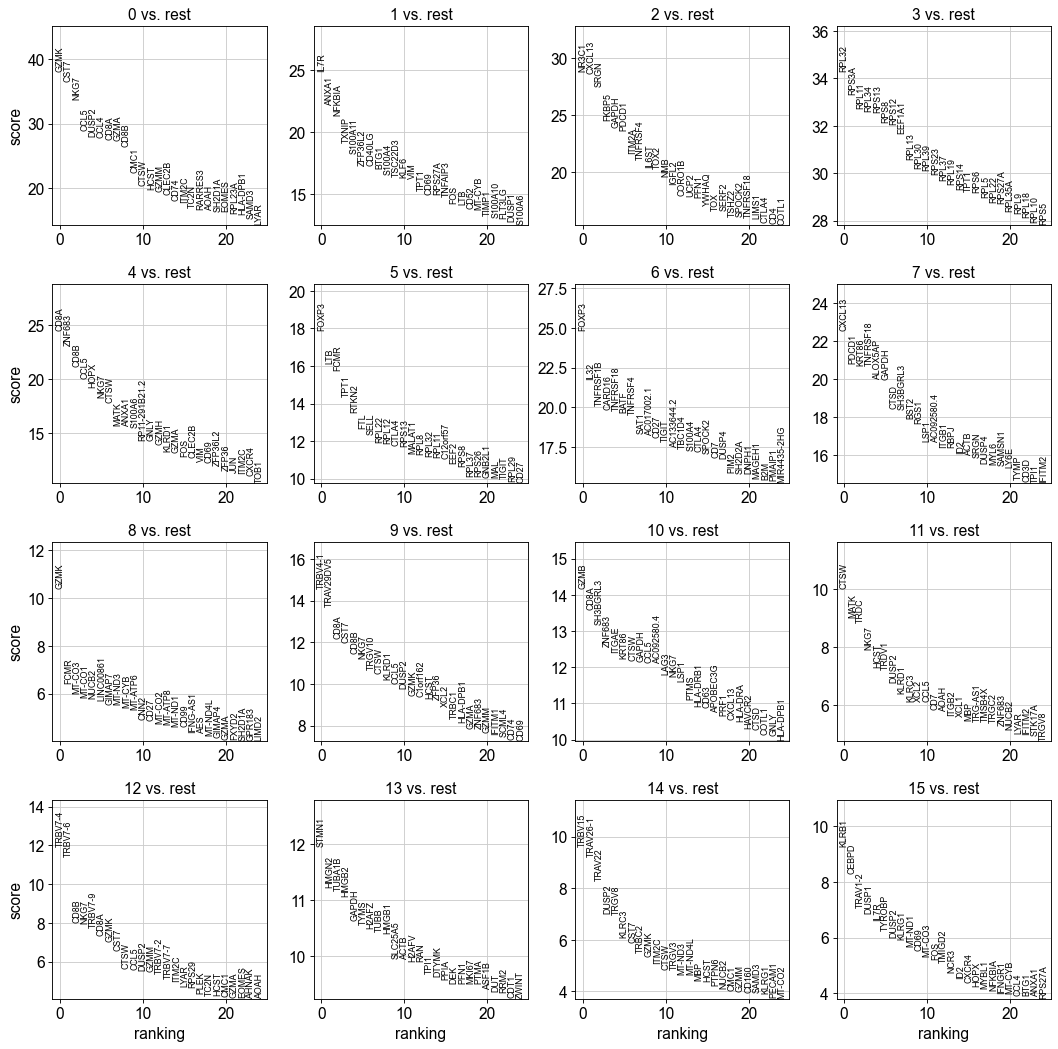

In [59]:
## Find marker genes
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [87]:
# Get names of most likely marker genes for each cluster
cluster_names = list(adata.uns['rank_genes_groups']['names'][0])

In [94]:
cluster_names = ['GZMK',
    'IL7R',
    'NR3C1',
    'RPL32',
    'CD8A',
    'FOXP3',
    'NOPE',
    'CXCL13',
    'NOPE2',
    'TRBV4-1',
    'GZMB',
    'CTSW',
    'TRBV7-4',
    'STMN1',
    'TRBV15',
    'KLRB1']

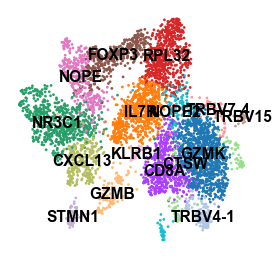

In [95]:
# Plot clusters
adata.rename_categories('leiden', cluster_names)
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False)

In [96]:
# Write results
adata.write(results_file)

In [106]:
adata

AnnData object with n_obs × n_vars = 4920 × 1017
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'leiden'
    var: 'gene_ids', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'